Note this approach doesn't really work. The network learns to pick the class with the most values at the expense of others. I hypothesis that this is due to the signal-noise problem when extracting patches. It is also due to the space between patches that is important.

The next thing to try is to bring-up our own CNN model with full image patch - scaled to constant size. 

## Patch based approach

Dataset

In [68]:
import os
import time
import numpy as np
import face_recognition
from skimage.transform import resize
from skimage.util import pad

%matplotlib inline
import matplotlib.pyplot as plt


LABELS = ['22q11','Angelman','Apert','CDL','Down','FragileX','Marfan','Progeria','Sotos','TreacherCollins','Turner','Williams']
KERNEL_SIZE = 32
IMAGE_PATCH_SIZE = 256
EXTRA_PAD = 32

LABELS.remove('CDL')


def load_dataset_patches(setPath):
    X = []
    Y = []

    for label in LABELS:
            
        directory = os.path.join(setPath,label)
        for f in os.listdir(directory):
            path = os.path.join(directory,f)
            
            if os.path.isfile(path) and f != 'desktop.ini':
                
                # Extract landmarks
                image = face_recognition.load_image_file(path)
                face_landmarks_list = face_recognition.face_landmarks(image)

                # Process faces
                for landmarks in face_landmarks_list:
                    
                    # find dimensions
                    top = image.shape[0]
                    bottom = 0
                    left = image.shape[1]
                    right = 0
                    
                    for featureType in landmarks.keys():
                        for point in landmarks[featureType]:
                            (x,y) = point
                            
                            if x < left:
                                left = x
                            if x > right:
                                right = x
                            if y < top:
                                top = y
                            if y > bottom:
                                bottom = y
                                
                    top = top - EXTRA_PAD if top - EXTRA_PAD >= 0 else 0
                    bottom = bottom + EXTRA_PAD if bottom + EXTRA_PAD < image.shape[0] else image.shape[0] - 1
                    left = left - EXTRA_PAD if left - EXTRA_PAD >= 0 else 0
                    right = right + EXTRA_PAD if right + EXTRA_PAD < image.shape[1] else image.shape[1] - 1
                    
                    # extract patch from image
                    img_patch = image[top:bottom,left:right,:]
                    img_patch_resized = resize(img_patch,(IMAGE_PATCH_SIZE,IMAGE_PATCH_SIZE,3))
                    img_pad_patch = pad(img_patch_resized,[
                        (KERNEL_SIZE, KERNEL_SIZE),
                        (KERNEL_SIZE, KERNEL_SIZE),
                        (0, 0)
                    ],'constant')
                    
                    # process points
                    point_patches = []
                    for featureType in landmarks.keys():
                        for point in landmarks[featureType]:
                            height = (bottom - top)
                            width = (right - left)
                            
                            # Transform coordinate system to face center
                            (x,y) = point
                            yc = y - top - height / 2
                            xc = x - left - width / 2
                            
                            # Find corresponding points in patch
                            ycp = yc * IMAGE_PATCH_SIZE / height
                            xcp = xc * IMAGE_PATCH_SIZE / width
                            
                            # Transform patch point coordinate system to patch origin (and account for padding)
                            yp = ycp + IMAGE_PATCH_SIZE / 2 + KERNEL_SIZE
                            xp = xcp + IMAGE_PATCH_SIZE / 2 + KERNEL_SIZE
                            
                            # Extract point-patch
                            point_patch = img_pad_patch[
                                int(yp-KERNEL_SIZE/2):int(yp+KERNEL_SIZE/2),
                                int(xp-KERNEL_SIZE/2):int(xp+KERNEL_SIZE/2),
                                :]
                            point_patches.append(point_patch)
                            if point_patch.shape != (32,32,3):
                                print(point_patch.shape)

                    X.append(point_patches)
                    Y.append(label)
                    
    # pack into numpy structure
    X_pack = np.zeros([len(X),KERNEL_SIZE,KERNEL_SIZE,72*3])
    for i in range(0,len(X)):
        for j in range(0,len(X[i])):
            X_pack[i,:,:,j*3:(j+1)*3] = X[i][j]
    Y_pack = np.array(Y)
    
    return X_pack, Y_pack

In [69]:
X_test, y_test = load_dataset_patches('./data/raw/Test')
print(X_test.shape)
print(y_test.shape)

(265, 32, 32, 216)
(265,)


In [70]:
X_train, y_train = load_dataset_patches('./data/raw/Train')
print(X_train.shape)
print(y_train.shape)

(862, 32, 32, 216)
(862,)


In [71]:
X_val, y_val = load_dataset_patches('./data/raw/Validate')
print(X_val.shape)
print(y_val.shape)

(258, 32, 32, 216)
(258,)


In [72]:
from sklearn.preprocessing import LabelBinarizer
encoder = LabelBinarizer()
Y_train = encoder.fit_transform(y_train)
Y_test = encoder.transform(y_test)
Y_val = encoder.transform(y_val)

print(Y_train.shape)
print(Y_test.shape)

(862, 11)
(265, 11)


Model

In [73]:
import keras

from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D

model = Sequential()
model.add(Conv2D(64, (7,7), activation='relu', input_shape=(32,32,72*3)))
model.add(Conv2D(64, (5,5), activation='relu'))
model.add(Conv2D(32, (5,5), activation='relu'))
model.add(Conv2D(32, (3,3), activation='relu'))
model.add(Conv2D(32, (3,3), activation='relu'))
#model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
#model.add(Dropout(0.5))
model.add(Dense(11, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_62 (Conv2D)           (None, 26, 26, 64)        677440    
_________________________________________________________________
conv2d_63 (Conv2D)           (None, 22, 22, 64)        102464    
_________________________________________________________________
conv2d_64 (Conv2D)           (None, 18, 18, 32)        51232     
_________________________________________________________________
conv2d_65 (Conv2D)           (None, 16, 16, 32)        9248      
_________________________________________________________________
conv2d_66 (Conv2D)           (None, 14, 14, 32)        9248      
_________________________________________________________________
flatten_15 (Flatten)         (None, 6272)              0         
_________________________________________________________________
dense_29 (Dense)             (None, 64)              

Train

In [74]:
history = model.fit(X_train, Y_train, batch_size=8, epochs=15, shuffle=True, validation_data=(X_val,Y_val))
print(history)

Train on 862 samples, validate on 258 samples
Epoch 1/15
862/862 [==============================] - 34s 39ms/step - loss: 2.6885 - accuracy: 0.1183 - val_loss: 1.9782 - val_accuracy: 0.1202
Epoch 2/15
862/862 [==============================] - 33s 39ms/step - loss: 2.1832 - accuracy: 0.1752 - val_loss: 2.4032 - val_accuracy: 0.0814
Epoch 3/15
862/862 [==============================] - 34s 39ms/step - loss: 2.1407 - accuracy: 0.1682 - val_loss: 2.1825 - val_accuracy: 0.5543
Epoch 4/15
862/862 [==============================] - 34s 39ms/step - loss: 2.1397 - accuracy: 0.1694 - val_loss: 2.3078 - val_accuracy: 0.0504
Epoch 5/15
862/862 [==============================] - 33s 39ms/step - loss: 2.1245 - accuracy: 0.1717 - val_loss: 2.2178 - val_accuracy: 0.0504
Epoch 6/15
862/862 [==============================] - 33s 39ms/step - loss: 2.1121 - accuracy: 0.1787 - val_loss: 2.1438 - val_accuracy: 0.0814
Epoch 7/15
862/862 [==============================] - 33s 39ms/step - loss: 2.1126 - accur

Evaluate

In [75]:
score = model.evaluate(X_train, Y_train, batch_size=32, verbose=1)
print('Train loss:', score[0])
print('Train accuracy:', score[1])

862/862 [==============================] - 8s 9ms/step
Train loss: 2.099910492686827
Train accuracy: 0.17865429818630219


In [76]:
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder

Y_pred = model.predict(X_train)
y_pred = encoder.inverse_transform(Y_pred)

conf = confusion_matrix(y_train, y_pred)

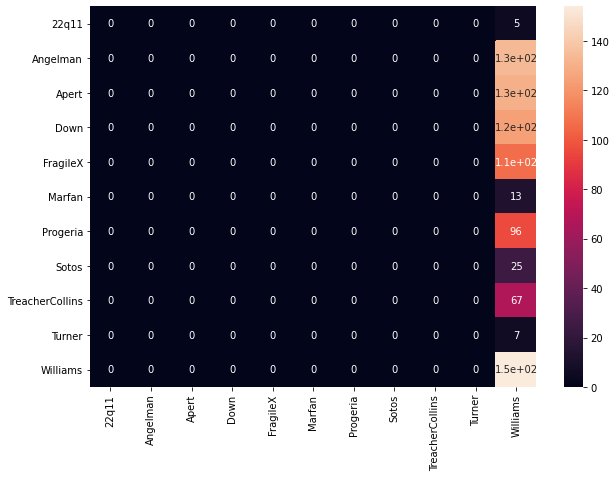

In [77]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(conf, index = [i for i in LABELS],
                  columns = [i for i in LABELS])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

In [78]:
score = model.evaluate(X_val, Y_val, batch_size=32, verbose=1)
print('Validation loss:', score[0])
print('Validation accuracy:', score[1])

258/258 [==============================] - 2s 9ms/step
Validation loss: 2.179004049116327
Validation accuracy: 0.08139535039663315


In [79]:
score = model.evaluate(X_test, Y_test, batch_size=32, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

265/265 [==============================] - 2s 9ms/step
Test loss: 2.0920120455184072
Test accuracy: 0.17358490824699402


In [80]:
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder

Y_pred = model.predict(X_test)
y_pred = encoder.inverse_transform(Y_pred)

conf = confusion_matrix(y_test, y_pred)

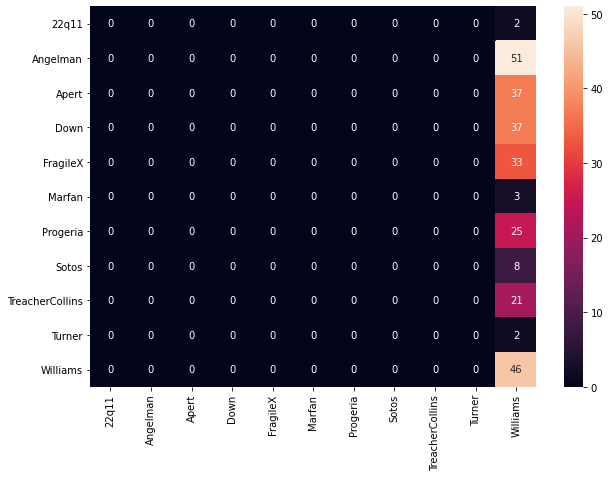

In [81]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(conf, index = [i for i in LABELS],
                  columns = [i for i in LABELS])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

Save

In [82]:
import time

save_dir = './models'
model_name = 'patch-classifier-{}.h5'.format(int(time.time()))

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save_weights(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at ./models/patch-classifier-1585678608.h5 
